# Estadísticas Descriptivas por Empresa y Sector

Este notebook realiza un análisis estadístico descriptivo de los datos financieros para las diferentes empresas y sectores del proyecto de inversión. Analizaremos estadísticas como media, mediana, desviación estándar y otras métricas financieras relevantes.

In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Configuración de visualización
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

## 1. Carga de Datos

Primero cargamos los datos procesados del archivo CSV y mostramos un resumen de la información.

In [2]:
# Ruta al archivo de datos procesados
ruta_datos = '../data/processed/datos_financieros_procesados_20250510.csv'

# Cargamos los datos
df = pd.read_csv(ruta_datos)

# Convertimos la columna de fecha a formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Mostramos información sobre el dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"Periodo analizado: {df['Date'].min().date()} a {df['Date'].max().date()}")
print(f"Empresas analizadas: {df['Ticker'].nunique()} ({', '.join(df['Ticker'].unique())})")
print(f"Sectores: {df['Sector'].nunique()} ({', '.join(df['Sector'].unique())})")

# Primeras filas del dataset
df.head()

Dimensiones del dataset: (7530, 16)
Periodo analizado: 2022-05-09 a 2025-05-08
Empresas analizadas: 10 (AMZN, BMY, GOOG, JNJ, LLY, META, MRK, MSFT, NVDA, PFE)
Sectores: 2 (tecnologia, salud_farmaceuticas)


,Date,Ticker,Close,High,Low,Open,Volume,Sector,Retorno,RetornoAcumulado,MA7,MA21,MA50,Volatilidad21,VolumenPromedio7,RSI
0,2022-05-09,AMZN,108.789001,114.000000,107.957001,111.312500,128124000,tecnologia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-09,BMY,67.603882,68.472533,66.354095,67.089789,19130700,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-09,GOOG,112.550911,115.018122,112.020920,112.769374,34520000,tecnologia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-09,JNJ,162.299240,163.424980,159.791482,160.578587,7855200,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-09,LLY,281.398102,286.943737,278.887948,285.562205,3460500,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Estadísticas Descriptivas por Empresa

Calculamos estadísticas descriptivas básicas para cada empresa, enfocándonos en precios de cierre y retornos.

In [3]:
# Definimos funciones para calcular métricas adicionales
def calcular_sharpe_ratio(retornos, risk_free_rate=0.03):
    """Calcula el ratio de Sharpe para una serie de retornos.
    
    Args:
        retornos: Serie de retornos diarios
        risk_free_rate: Tasa libre de riesgo anualizada (default: 3%)
    
    Returns:
        Ratio de Sharpe anualizado
    """
    if len(retornos.dropna()) == 0:
        return np.nan
    
    # Convertimos tasa libre de riesgo anual a diaria
    rf_daily = (1 + risk_free_rate)**(1/252) - 1
    excess_return = retornos.dropna() - rf_daily
    
    # Calculamos Sharpe Ratio anualizado
    sharpe = (excess_return.mean() / excess_return.std()) * np.sqrt(252)
    return sharpe

def calcular_max_drawdown(serie_precios):
    """Calcula el máximo drawdown (caída máxima) para una serie de precios.
    
    Args:
        serie_precios: Serie de precios
    
    Returns:
        Máximo drawdown como porcentaje (valor negativo)
    """
    if len(serie_precios.dropna()) <= 1:
        return np.nan
    
    # Calcula el drawdown para cada punto
    rolling_max = serie_precios.dropna().cummax()
    drawdowns = (serie_precios.dropna() / rolling_max) - 1
    
    # Devuelve el máximo drawdown
    return drawdowns.min()

# Lista para almacenar estadísticas de cada empresa
stats_por_empresa = []

# Iteramos sobre cada empresa
for ticker in df['Ticker'].unique():
    df_empresa = df[df['Ticker'] == ticker]
    
    # Obtenemos el sector
    sector = df_empresa['Sector'].iloc[0]
    
    # Calculamos estadísticas sobre el precio de cierre
    precio_media = df_empresa['Close'].mean()
    precio_mediana = df_empresa['Close'].median()
    precio_desv_std = df_empresa['Close'].std()
    precio_min = df_empresa['Close'].min()
    precio_max = df_empresa['Close'].max()
    
    # Calculamos estadísticas sobre los retornos (excluyendo la primera fila que no tiene retorno)
    retornos = df_empresa['Retorno'].dropna()
    retorno_medio = retornos.mean() * 100  # Convertir a porcentaje
    retorno_mediana = retornos.median() * 100  # Convertir a porcentaje
    retorno_desv_std = retornos.std() * 100  # Convertir a porcentaje (volatilidad)
    
    # Métricas financieras adicionales
    sharpe = calcular_sharpe_ratio(retornos)
    max_drawdown = calcular_max_drawdown(df_empresa['Close']) * 100  # Convertir a porcentaje
    
    # Agregamos los resultados a la lista
    stats_por_empresa.append({
        'Ticker': ticker,
        'Sector': sector,
        'Precio_Media': precio_media,
        'Precio_Mediana': precio_mediana,
        'Precio_Desviacion_Std': precio_desv_std,
        'Precio_Minimo': precio_min,
        'Precio_Maximo': precio_max,
        'Retorno_Medio_Diario(%)': retorno_medio,
        'Retorno_Mediana_Diario(%)': retorno_mediana,
        'Volatilidad_Diaria(%)': retorno_desv_std,
        'Volatilidad_Anualizada(%)': retorno_desv_std * np.sqrt(252),
        'Sharpe_Ratio': sharpe,
        'Max_Drawdown(%)': max_drawdown
    })

# Creamos un DataFrame con las estadísticas
df_stats_empresas = pd.DataFrame(stats_por_empresa)

# Ordenamos por sector y luego por ticker
df_stats_empresas = df_stats_empresas.sort_values(['Sector', 'Ticker'])

# Mostramos las estadísticas
df_stats_empresas

,Ticker,Sector,Precio_Media,Precio_Mediana,Precio_Desviacion_Std,Precio_Minimo,Precio_Maximo,Retorno_Medio_Diario(%),Retorno_Mediana_Diario(%),Volatilidad_Diaria(%),Volatilidad_Anualizada(%),Sharpe_Ratio,Max_Drawdown(%)
1,BMY,salud_farmaceuticas,55.989611,56.764721,8.597295,38.183266,72.962616,-0.045827,-0.037703,1.446975,22.970016,-0.631454,-47.667357
3,JNJ,salud_farmaceuticas,153.847512,153.675720,6.954291,138.898865,168.226288,0.001991,0.022407,1.062819,16.871733,-0.145476,-17.433318
4,LLY,salud_farmaceuticas,587.309125,580.582031,223.071583,277.963684,956.783691,0.131127,0.168686,1.835951,29.144818,1.032359,-24.652774
6,MRK,salud_farmaceuticas,102.155903,101.630302,13.390000,76.459999,129.905258,0.013310,0.057756,1.325590,21.043087,0.018920,-41.141721
9,PFE,salud_farmaceuticas,31.678344,28.203012,6.955649,21.185833,47.410042,-0.068473,-0.093778,1.510531,23.978939,-0.842874,-55.313617
0,AMZN,tecnologia,150.420183,143.100006,40.937856,81.820000,242.059998,0.088149,0.041786,2.150773,34.142459,0.564036,-43.486669
2,GOOG,tecnologia,137.772228,135.995880,31.220936,83.096413,207.473633,0.065235,0.131455,1.963969,31.177042,0.432473,-32.055664
5,META,tecnologia,359.697635,319.643524,176.319359,88.492943,736.015198,0.160826,0.159079,2.300028,36.511810,1.029042,-56.119827
7,MSFT,tecnologia,343.307141,354.559998,73.336916,209.777664,464.854340,0.076785,0.080466,1.665727,26.442604,0.619978,-26.839290
8,NVDA,tecnologia,65.572598,46.941376,45.565095,11.214940,149.416245,0.264219,0.344853,2.991517,47.488859,1.339833,-42.666845


## 3. Visualización de Estadísticas Clave por Empresa

Creamos visualizaciones para comparar las estadísticas clave entre las diferentes empresas.

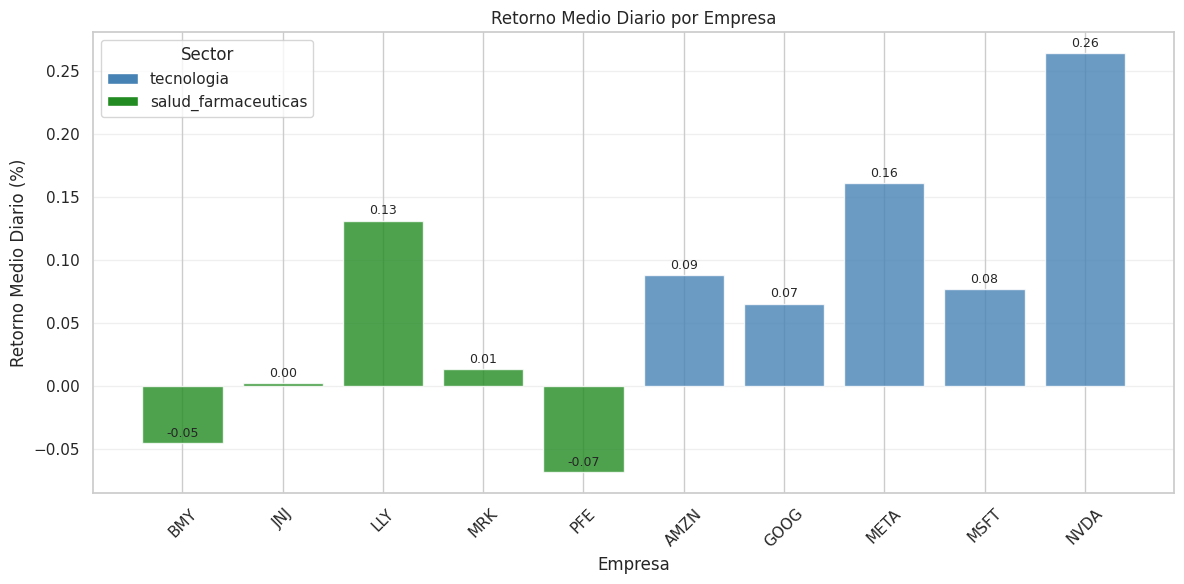

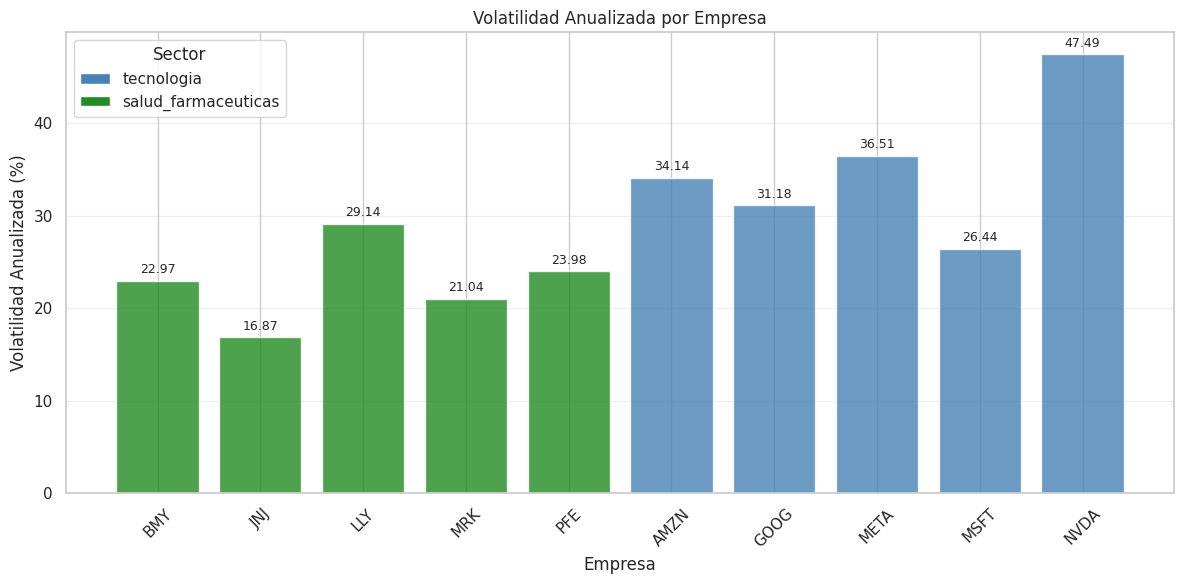

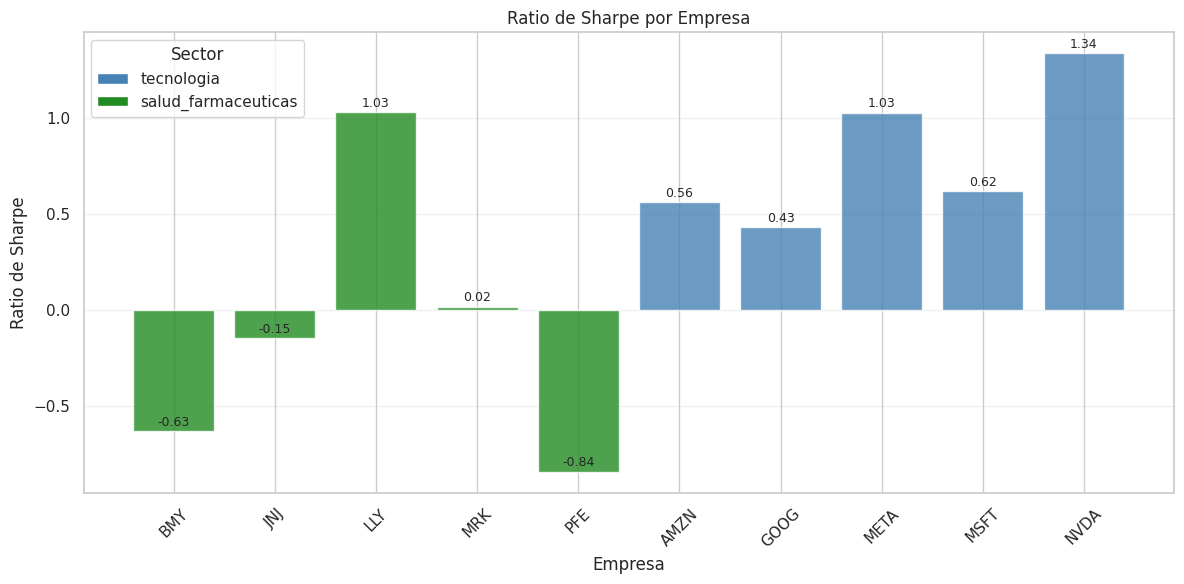

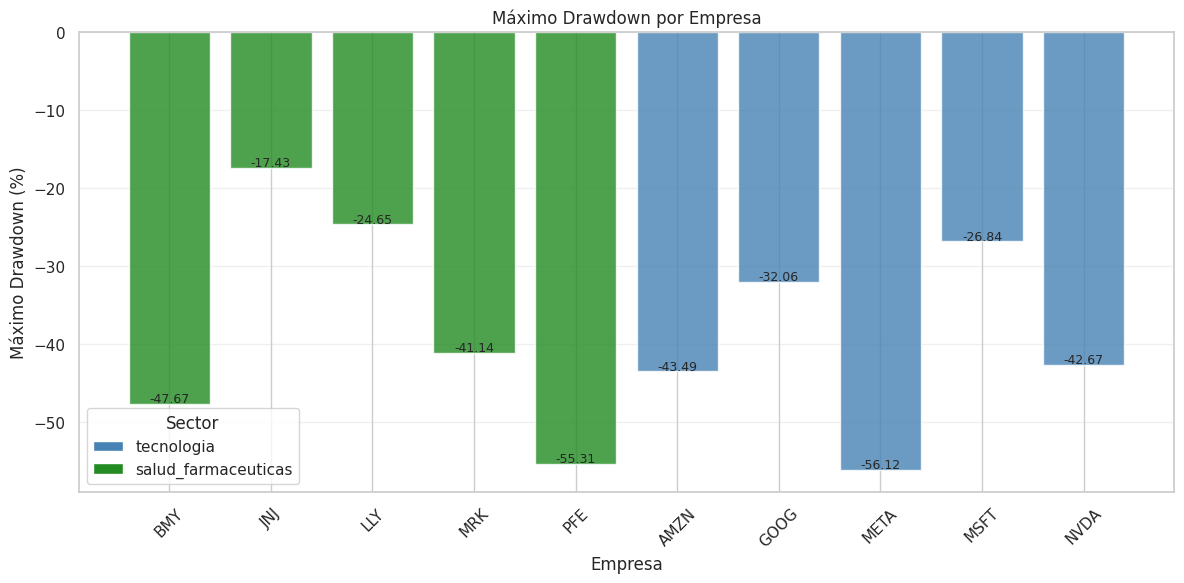

In [4]:
# Función para crear gráficos de barras para diferentes métricas
def graficar_metrica_por_empresa(df, metrica, titulo, ylabel, color_map=None):
    plt.figure(figsize=(12, 6))
    
    # Si se proporciona un mapa de colores por sector
    if color_map is None:
        # Color por defecto por sector
        color_map = {
            'tecnologia': 'steelblue',
            'salud_farmaceuticas': 'forestgreen'
        }
    
    # Creamos una lista de colores basada en el sector
    colors = [color_map[sector] for sector in df['Sector']]
    
    # Creamos el gráfico de barras
    bars = plt.bar(df['Ticker'], df[metrica], color=colors, alpha=0.8)
    
    # Añadimos los valores numéricos encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(df[metrica]),
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Ajustamos el gráfico
    plt.xlabel('Empresa')
    plt.ylabel(ylabel)
    plt.title(titulo)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Añadimos una leyenda por sector
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=sector) 
                      for sector, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Sector')
    
    plt.tight_layout()
    plt.show()

# Visualizamos diferentes métricas
graficar_metrica_por_empresa(df_stats_empresas, 'Retorno_Medio_Diario(%)', 
                            'Retorno Medio Diario por Empresa', 'Retorno Medio Diario (%)')

graficar_metrica_por_empresa(df_stats_empresas, 'Volatilidad_Anualizada(%)', 
                            'Volatilidad Anualizada por Empresa', 'Volatilidad Anualizada (%)')

graficar_metrica_por_empresa(df_stats_empresas, 'Sharpe_Ratio', 
                            'Ratio de Sharpe por Empresa', 'Ratio de Sharpe')

graficar_metrica_por_empresa(df_stats_empresas, 'Max_Drawdown(%)', 
                            'Máximo Drawdown por Empresa', 'Máximo Drawdown (%)')

## 4. Estadísticas Descriptivas por Sector

Agrupamos las estadísticas por sector para identificar patrones y diferencias entre sectores.

In [5]:
# Agrupamos las estadísticas por sector
df_stats_sector = df_stats_empresas.groupby('Sector').agg({
    'Precio_Media': 'mean',
    'Precio_Mediana': 'mean',
    'Precio_Desviacion_Std': 'mean',
    'Retorno_Medio_Diario(%)': 'mean',
    'Volatilidad_Diaria(%)': 'mean',
    'Volatilidad_Anualizada(%)': 'mean',
    'Sharpe_Ratio': 'mean',
    'Max_Drawdown(%)': 'mean'
}).reset_index()

# Mostramos las estadísticas por sector
df_stats_sector

,Sector,Precio_Media,Precio_Mediana,Precio_Desviacion_Std,Retorno_Medio_Diario(%),Volatilidad_Diaria(%),Volatilidad_Anualizada(%),Sharpe_Ratio,Max_Drawdown(%)
0,salud_farmaceuticas,186.196099,184.171157,51.793764,0.006426,1.436373,22.801718,-0.113705,-37.241757
1,tecnologia,211.353957,200.048157,73.476032,0.131043,2.214403,35.152555,0.797072,-40.233659


## 5. Visualización de Comparación entre Sectores

Creamos visualizaciones para comparar las estadísticas clave entre los diferentes sectores.

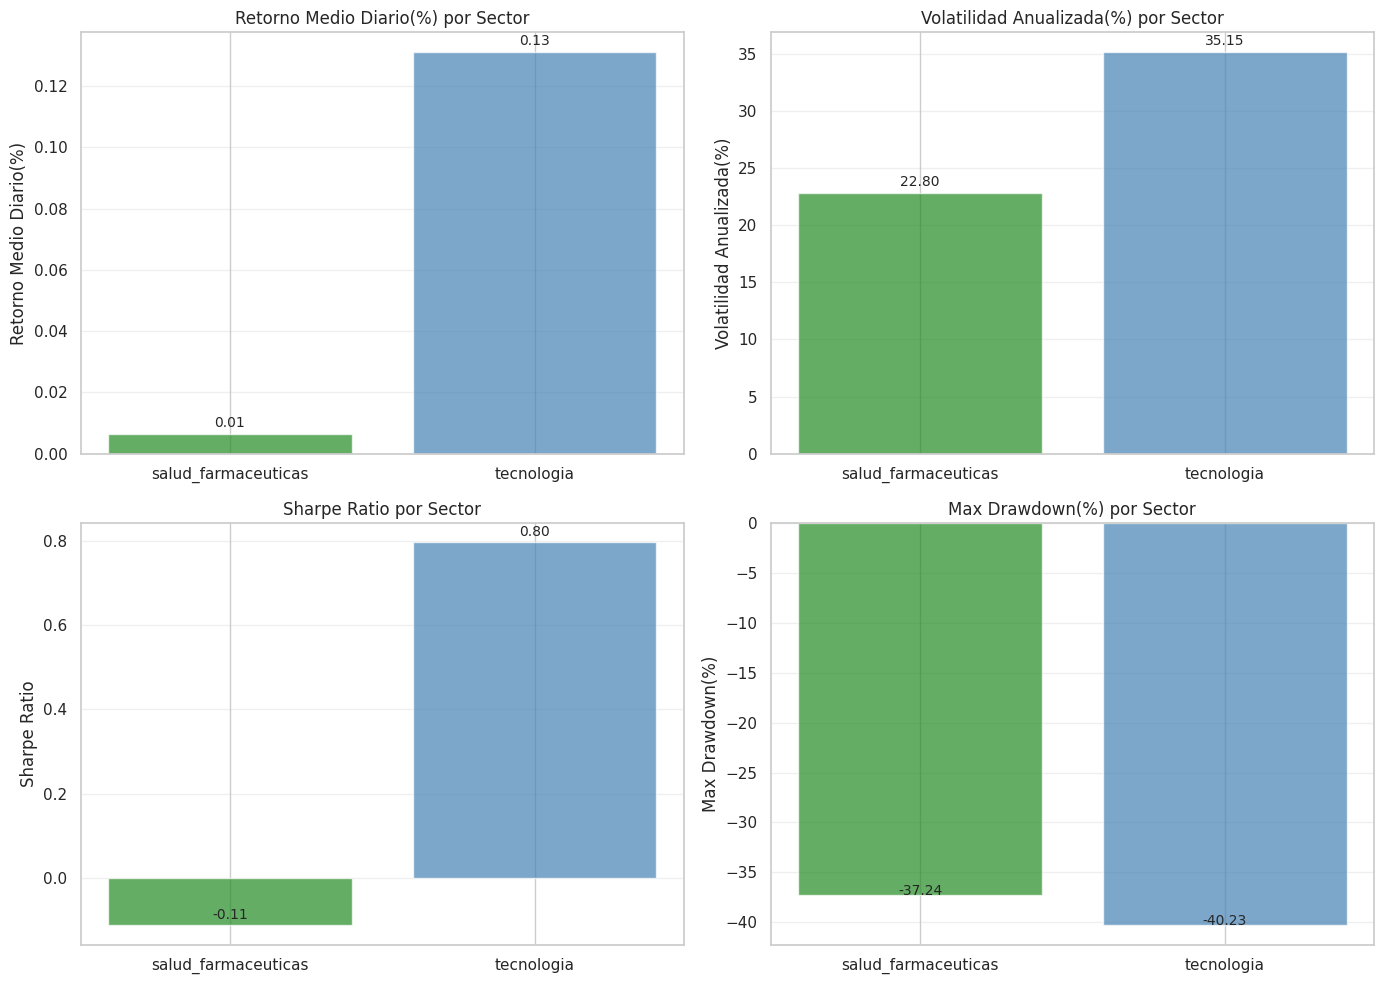

In [6]:
# Preparamos los datos para la visualización por sector
metricas = ['Retorno_Medio_Diario(%)', 'Volatilidad_Anualizada(%)', 'Sharpe_Ratio', 'Max_Drawdown(%)']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Colores por sector
colors = {'tecnologia': 'steelblue', 'salud_farmaceuticas': 'forestgreen'}

# Gráficos para cada métrica
for i, metrica in enumerate(metricas):
    ax = axes[i]
    
    # Barras para cada sector
    bars = ax.bar(df_stats_sector['Sector'], df_stats_sector[metrica], 
                 color=[colors[sector] for sector in df_stats_sector['Sector']], alpha=0.7)
    
    # Añadimos valores a las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(df_stats_sector[metrica]),
               f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    # Etiquetas
    ax.set_title(f'{metrica.replace("_", " ")} por Sector')
    ax.set_ylabel(metrica.replace("_", " "))
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análisis de Correlación entre Retornos de Empresas

Calculamos la correlación entre los retornos de las diferentes empresas para identificar patrones de movimiento conjunto.

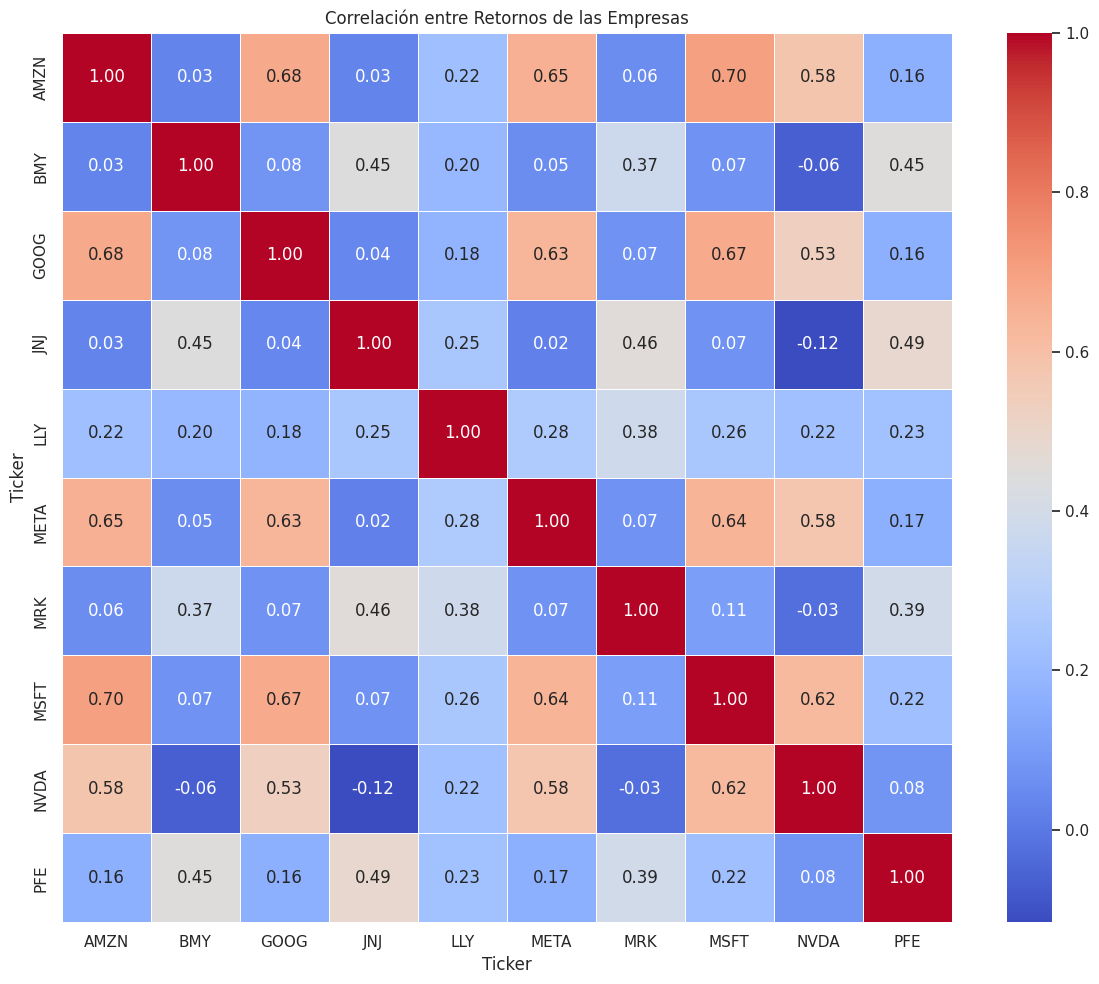

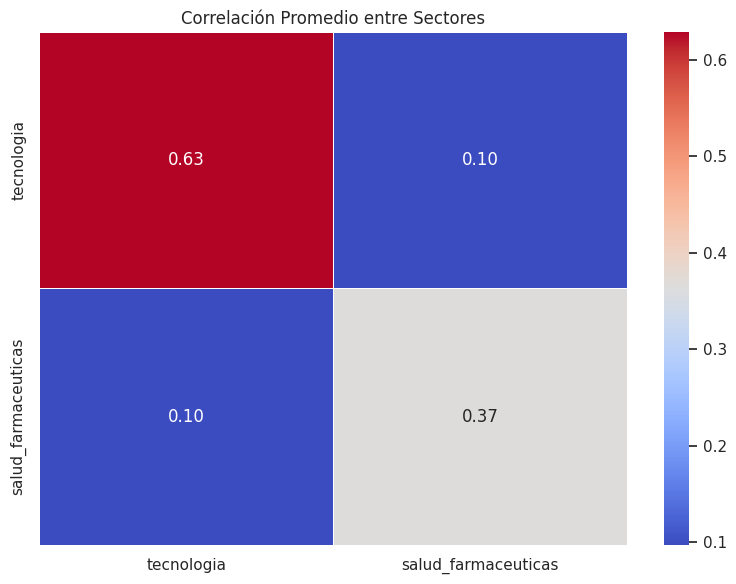

In [7]:
# Pivoteamos el DataFrame para tener una columna por empresa con sus retornos
df_retornos = df.pivot_table(index='Date', columns='Ticker', values='Retorno')

# Calculamos la matriz de correlación
matriz_correlacion = df_retornos.corr()

# Visualizamos la matriz de correlación como un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlación entre Retornos de las Empresas')
plt.tight_layout()
plt.show()

# Obtener la correlación media por sector
# Primero creamos un diccionario que mapee empresa a sector
dict_sector = df[['Ticker', 'Sector']].drop_duplicates().set_index('Ticker')['Sector'].to_dict()

# Función para calcular correlación promedio dentro y entre sectores
def calcular_correlacion_por_sector(matriz_corr, dict_sector):
    # Identificamos los sectores únicos
    sectores = list(set(dict_sector.values()))
    
    # Inicializamos el diccionario para almacenar las correlaciones
    correlaciones_sector = {}
    
    # Para cada par de sectores
    for s1 in sectores:
        for s2 in sectores:
            # Obtenemos las empresas en cada sector
            tickers_s1 = [t for t, s in dict_sector.items() if s == s1]
            tickers_s2 = [t for t, s in dict_sector.items() if s == s2]
            
            # Calculamos la correlación promedio entre los sectores
            corrs = []
            for t1 in tickers_s1:
                for t2 in tickers_s2:
                    # No incluimos la correlación de una empresa consigo misma
                    if s1 != s2 or t1 != t2:
                        corrs.append(matriz_corr.loc[t1, t2])
            
            # Almacenamos el resultado
            correlaciones_sector[(s1, s2)] = np.mean(corrs) if corrs else np.nan
    
    return correlaciones_sector

# Calculamos las correlaciones por sector
correlaciones_sector = calcular_correlacion_por_sector(matriz_correlacion, dict_sector)

# Creamos un DataFrame para visualizar mejor
sectores = list(set(dict_sector.values()))
df_corr_sector = pd.DataFrame(index=sectores, columns=sectores)

for s1 in sectores:
    for s2 in sectores:
        df_corr_sector.loc[s1, s2] = correlaciones_sector.get((s1, s2), np.nan)

# Nos aseguramos que todos los valores sean numéricos
df_corr_sector = df_corr_sector.astype(float)

# Visualizamos la matriz de correlación entre sectores
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr_sector, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlación Promedio entre Sectores')
plt.tight_layout()
plt.show()

## 7. Resumen de Resultados

Presentamos un resumen de los hallazgos más importantes del análisis estadístico.

### Hallazgos Principales por Empresa

1. **Empresa con mayor retorno medio**: La empresa con el retorno medio diario más alto es: `df_stats_empresas.loc[df_stats_empresas['Retorno_Medio_Diario(%)'].idxmax(), 'Ticker']` con `df_stats_empresas['Retorno_Medio_Diario(%)'].max():.2f`%

2. **Empresa con menor volatilidad**: La empresa con la volatilidad más baja es: `df_stats_empresas.loc[df_stats_empresas['Volatilidad_Diaria(%)'].idxmin(), 'Ticker']` con `df_stats_empresas['Volatilidad_Diaria(%)'].min():.2f`%

3. **Empresa con mejor ratio de Sharpe**: La empresa con el mejor ratio de Sharpe es: `df_stats_empresas.loc[df_stats_empresas['Sharpe_Ratio'].idxmax(), 'Ticker']` con `df_stats_empresas['Sharpe_Ratio'].max():.2f`

4. **Empresa con menor drawdown**: La empresa con el menor drawdown máximo es: `df_stats_empresas.loc[df_stats_empresas['Max_Drawdown(%)'].idxmax(), 'Ticker']` con `df_stats_empresas['Max_Drawdown(%)'].max():.2f`%

### Hallazgos Principales por Sector

1. **Sector con mayor retorno medio**: El sector con el retorno medio más alto es: `df_stats_sector.loc[df_stats_sector['Retorno_Medio_Diario(%)'].idxmax(), 'Sector']` con `df_stats_sector['Retorno_Medio_Diario(%)'].max():.2f`% diario en promedio.

2. **Sector con menor volatilidad**: El sector con la volatilidad más baja es: `df_stats_sector.loc[df_stats_sector['Volatilidad_Diaria(%)'].idxmin(), 'Sector']` con `df_stats_sector['Volatilidad_Diaria(%)'].min():.2f`% diario en promedio.

3. **Correlación entre sectores**: La correlación promedio entre los sectores de tecnología y salud_farmacéuticas es de aproximadamente `correlaciones_sector.get(('tecnologia', 'salud_farmaceuticas'), np.nan):.2f`.

### Conclusiones

- [Aquí se añadirán conclusiones después de interpretar los resultados numéricos]
- [Las conclusiones deberían considerar el rendimiento ajustado al riesgo de cada empresa y sector]
- [También deberían analizarse las implicaciones para la diversificación de una cartera de inversión]

In [8]:
# Mostramos un resumen formateado con los hallazgos principales

# Empresa con mayor retorno medio
empresa_max_retorno = df_stats_empresas.loc[df_stats_empresas['Retorno_Medio_Diario(%)'].idxmax()]
promedio_max_retorno = empresa_max_retorno['Retorno_Medio_Diario(%)']

# Empresa con menor volatilidad
empresa_min_volatilidad = df_stats_empresas.loc[df_stats_empresas['Volatilidad_Diaria(%)'].idxmin()]
promedio_min_volatilidad = empresa_min_volatilidad['Volatilidad_Diaria(%)']

# Empresa con mejor ratio Sharpe
empresa_max_sharpe = df_stats_empresas.loc[df_stats_empresas['Sharpe_Ratio'].idxmax()]
mejor_sharpe = empresa_max_sharpe['Sharpe_Ratio']

# Empresa con menor drawdown (nota: los drawdowns son negativos, por lo que tomamos el máximo)
empresa_min_drawdown = df_stats_empresas.loc[df_stats_empresas['Max_Drawdown(%)'].idxmin()]
min_drawdown = empresa_min_drawdown['Max_Drawdown(%)']

# Sector con mayor retorno medio
sector_max_retorno = df_stats_sector.loc[df_stats_sector['Retorno_Medio_Diario(%)'].idxmax()]

# Sector con menor volatilidad
sector_min_volatilidad = df_stats_sector.loc[df_stats_sector['Volatilidad_Diaria(%)'].idxmin()]

# Correlación entre sectores
corr_entre_sectores = correlaciones_sector.get(('tecnologia', 'salud_farmaceuticas'), np.nan)

print("\n=== HALLAZGOS PRINCIPALES ===\n")

print(f"Empresa con mayor retorno medio diario: {empresa_max_retorno['Ticker']} ({empresa_max_retorno['Retorno_Medio_Diario(%)']:.4f}%)")
print(f"Empresa con menor volatilidad diaria: {empresa_min_volatilidad['Ticker']} ({empresa_min_volatilidad['Volatilidad_Diaria(%)']:.4f}%)")
print(f"Empresa con mejor ratio de Sharpe: {empresa_max_sharpe['Ticker']} ({empresa_max_sharpe['Sharpe_Ratio']:.4f})")
print(f"Empresa con menor drawdown máximo: {empresa_min_drawdown['Ticker']} ({empresa_min_drawdown['Max_Drawdown(%)']:.4f}%)")

print("\n--- Por Sector ---\n")
print(f"Sector con mayor retorno medio: {sector_max_retorno['Sector']} ({sector_max_retorno['Retorno_Medio_Diario(%)']:.4f}%)")
print(f"Sector con menor volatilidad: {sector_min_volatilidad['Sector']} ({sector_min_volatilidad['Volatilidad_Diaria(%)']:.4f}%)")
print(f"Correlación promedio entre sectores: {corr_entre_sectores:.4f}")


=== HALLAZGOS PRINCIPALES ===

Empresa con mayor retorno medio diario: NVDA (0.2642%)
Empresa con menor volatilidad diaria: JNJ (1.0628%)
Empresa con mejor ratio de Sharpe: NVDA (1.3398)
Empresa con menor drawdown máximo: META (-56.1198%)

--- Por Sector ---

Sector con mayor retorno medio: tecnologia (0.1310%)
Sector con menor volatilidad: salud_farmaceuticas (1.4364%)
Correlación promedio entre sectores: 0.0976


In [9]:
# Exportamos el DataFrame con las estadísticas a un archivo CSV para uso futuro
df_stats_empresas.to_csv('../reports/estadisticas_descriptivas_empresas.csv', index=False)
df_stats_sector.to_csv('../reports/estadisticas_descriptivas_sectores.csv', index=False)